# Kalman Filter for LUNA Modelling

## Explanation

In order to predict drop out, we can start by estimating an underlying latent variable ("intent to drop out"). My Understanding is, that this is mostly measured by the PANNP (etc) items. We can map these items into a latent space using the loadings found via CFA. With these, we can then measure and predict the "intent to drop out".

### Assumption: The loadings do infact measure this latent factor! We need to check this!

## Usage

See below for an example. The model at this point only runs on a per-person basis. 

## Next steps

1. Get this running on real data
2. Deploy
3. We can probably extend this into a type of multi-level model, by passing all students in a class, with a given covariance structure.


In [256]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [257]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0
        self.predictions = np.array([])

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x, self.P

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)


## Example Usage

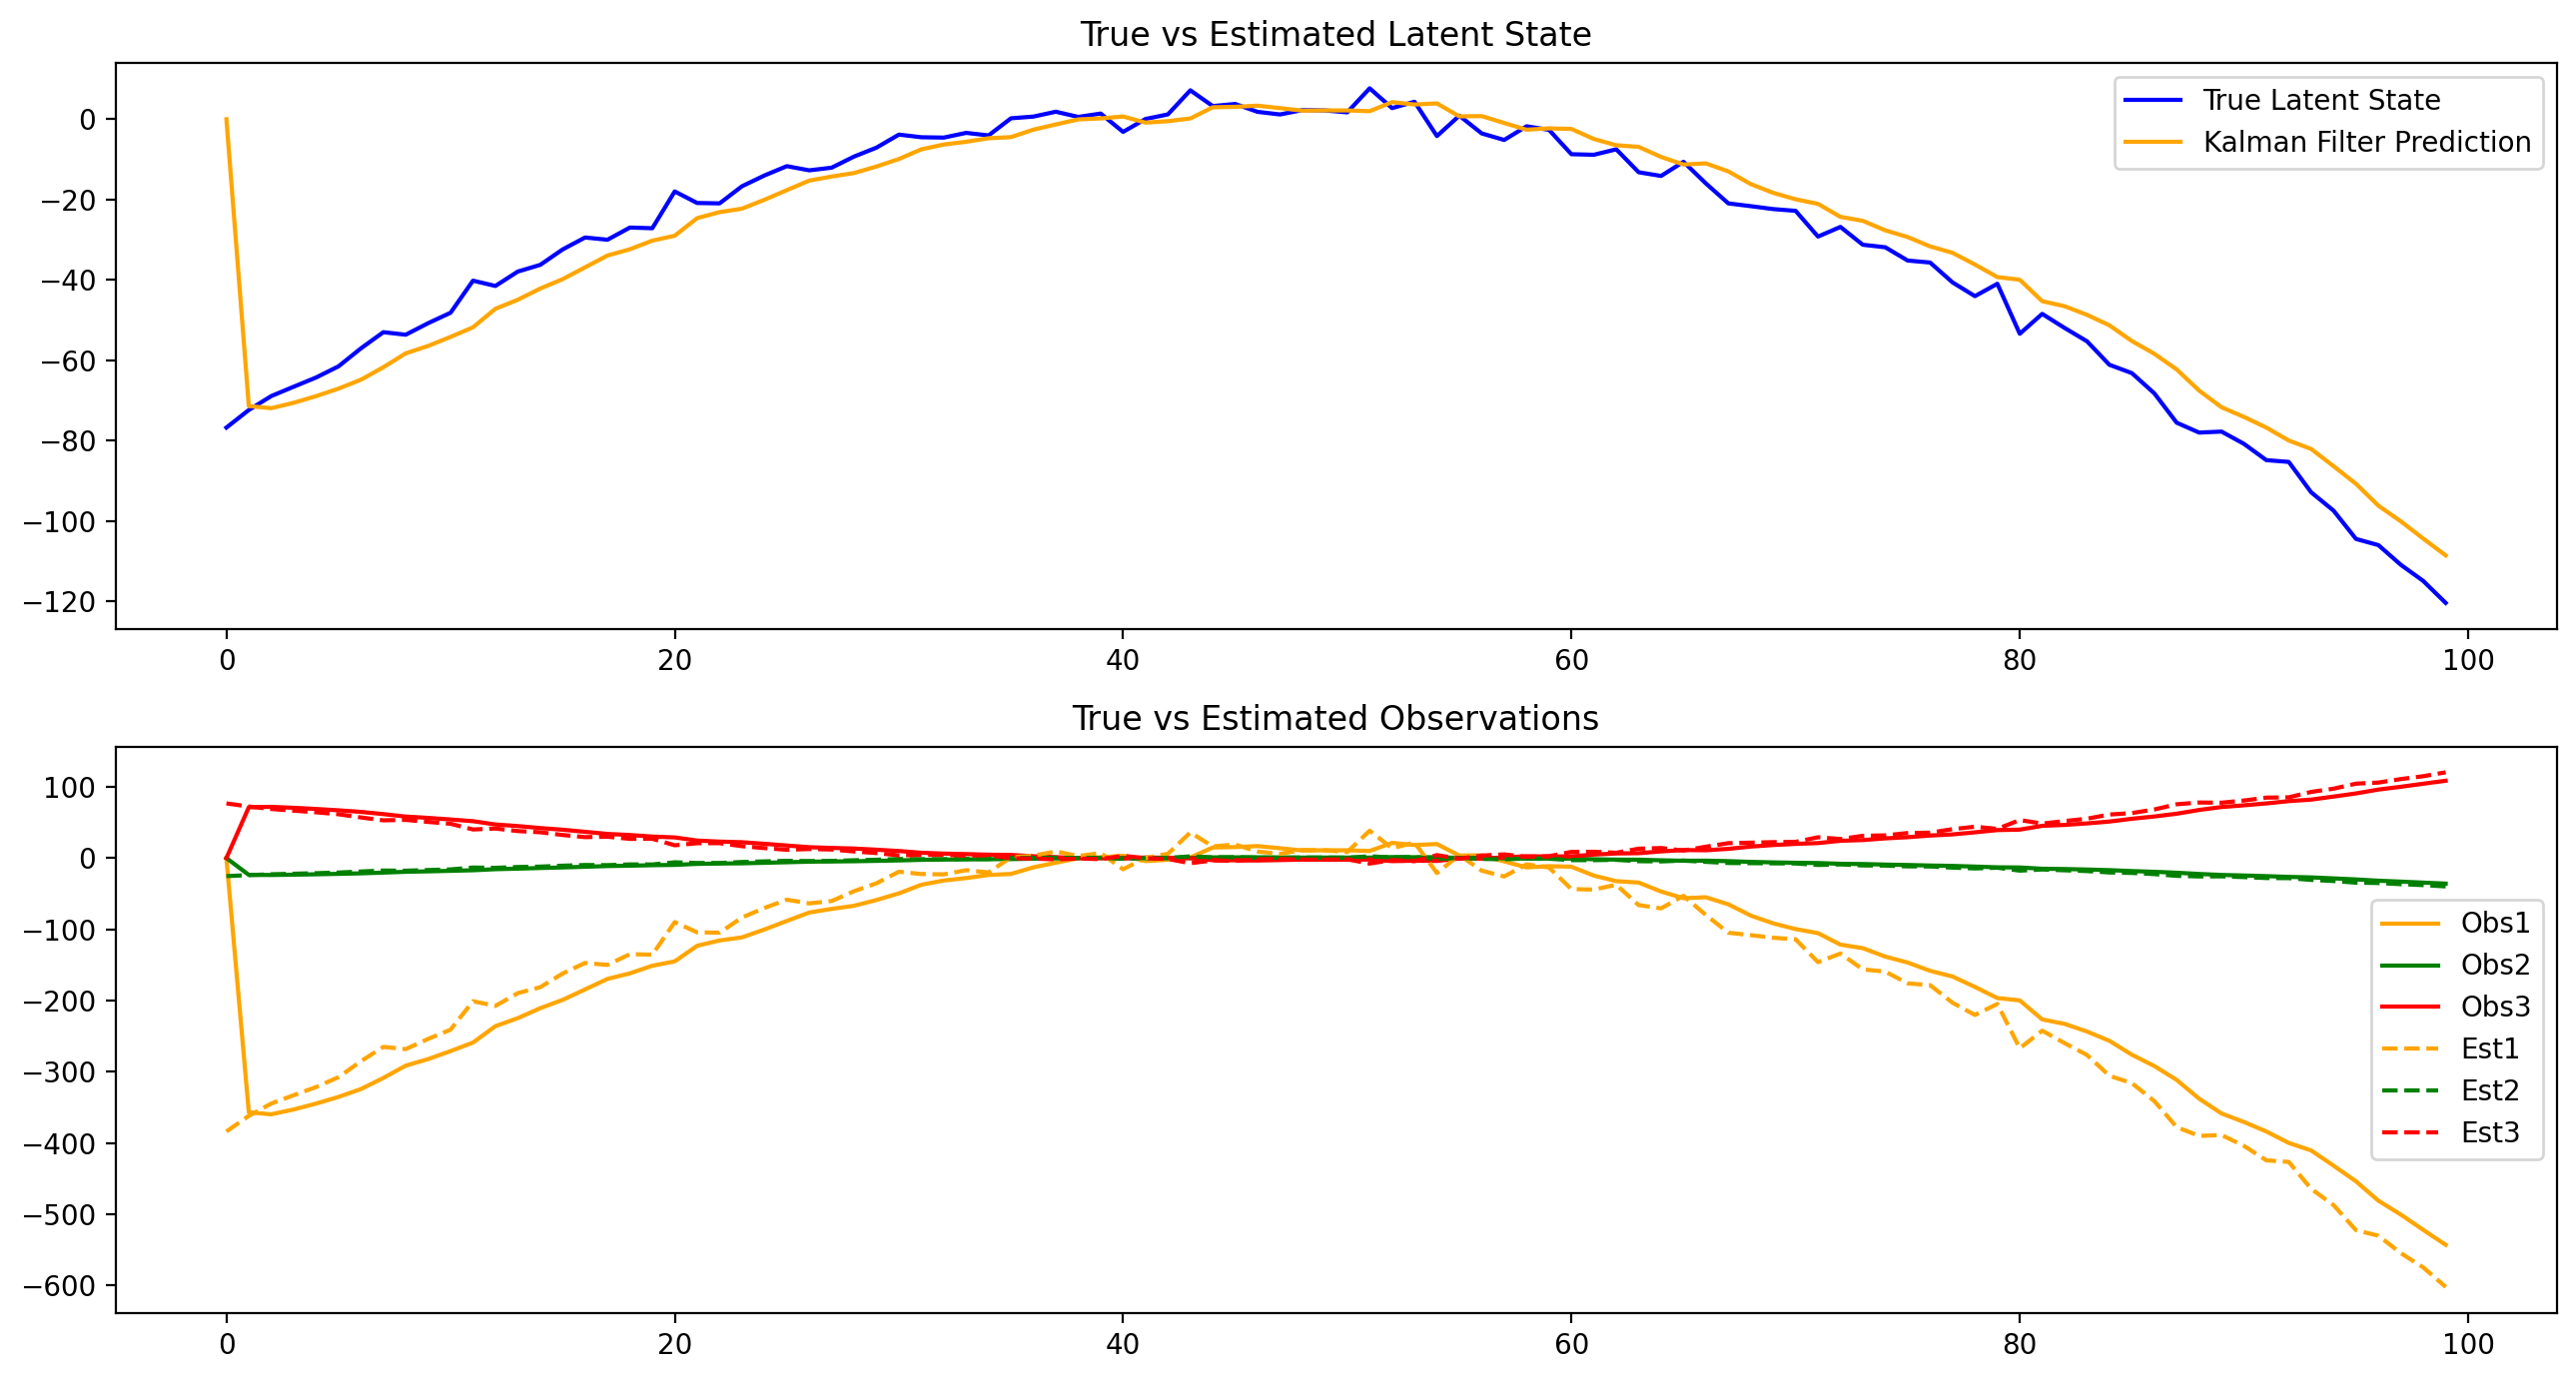

In [265]:
F = np.array([[1]])  # Assuming no change in state

H = np.array([[5],  # First observation directly maps to the state
              [0.33],  # Second observation directly maps to the state
              [-1]]) # Third observation directly maps to the state

Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]]) # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


x = np.linspace(-10, 10, 100)
latent_state = (- (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)).reshape(1,100)
observations = H @ latent_state



kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state = []
predictions_obs = []

for z in observations.T:
    z = z.reshape(3,1)
    predictions_obs.append(H @ kf.predict()[0])
    predictions_state.append(kf.predict()[0])
    kf.update(z)

import matplotlib.pyplot as plt

# Assuming predictions_obs, observations, latent_state, and predictions are defined

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(latent_state.T)), latent_state.T, label='True Latent State', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(100,1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("True vs Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(100, 3)[:, i], label=f"Obs{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Est{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()


## Another Example

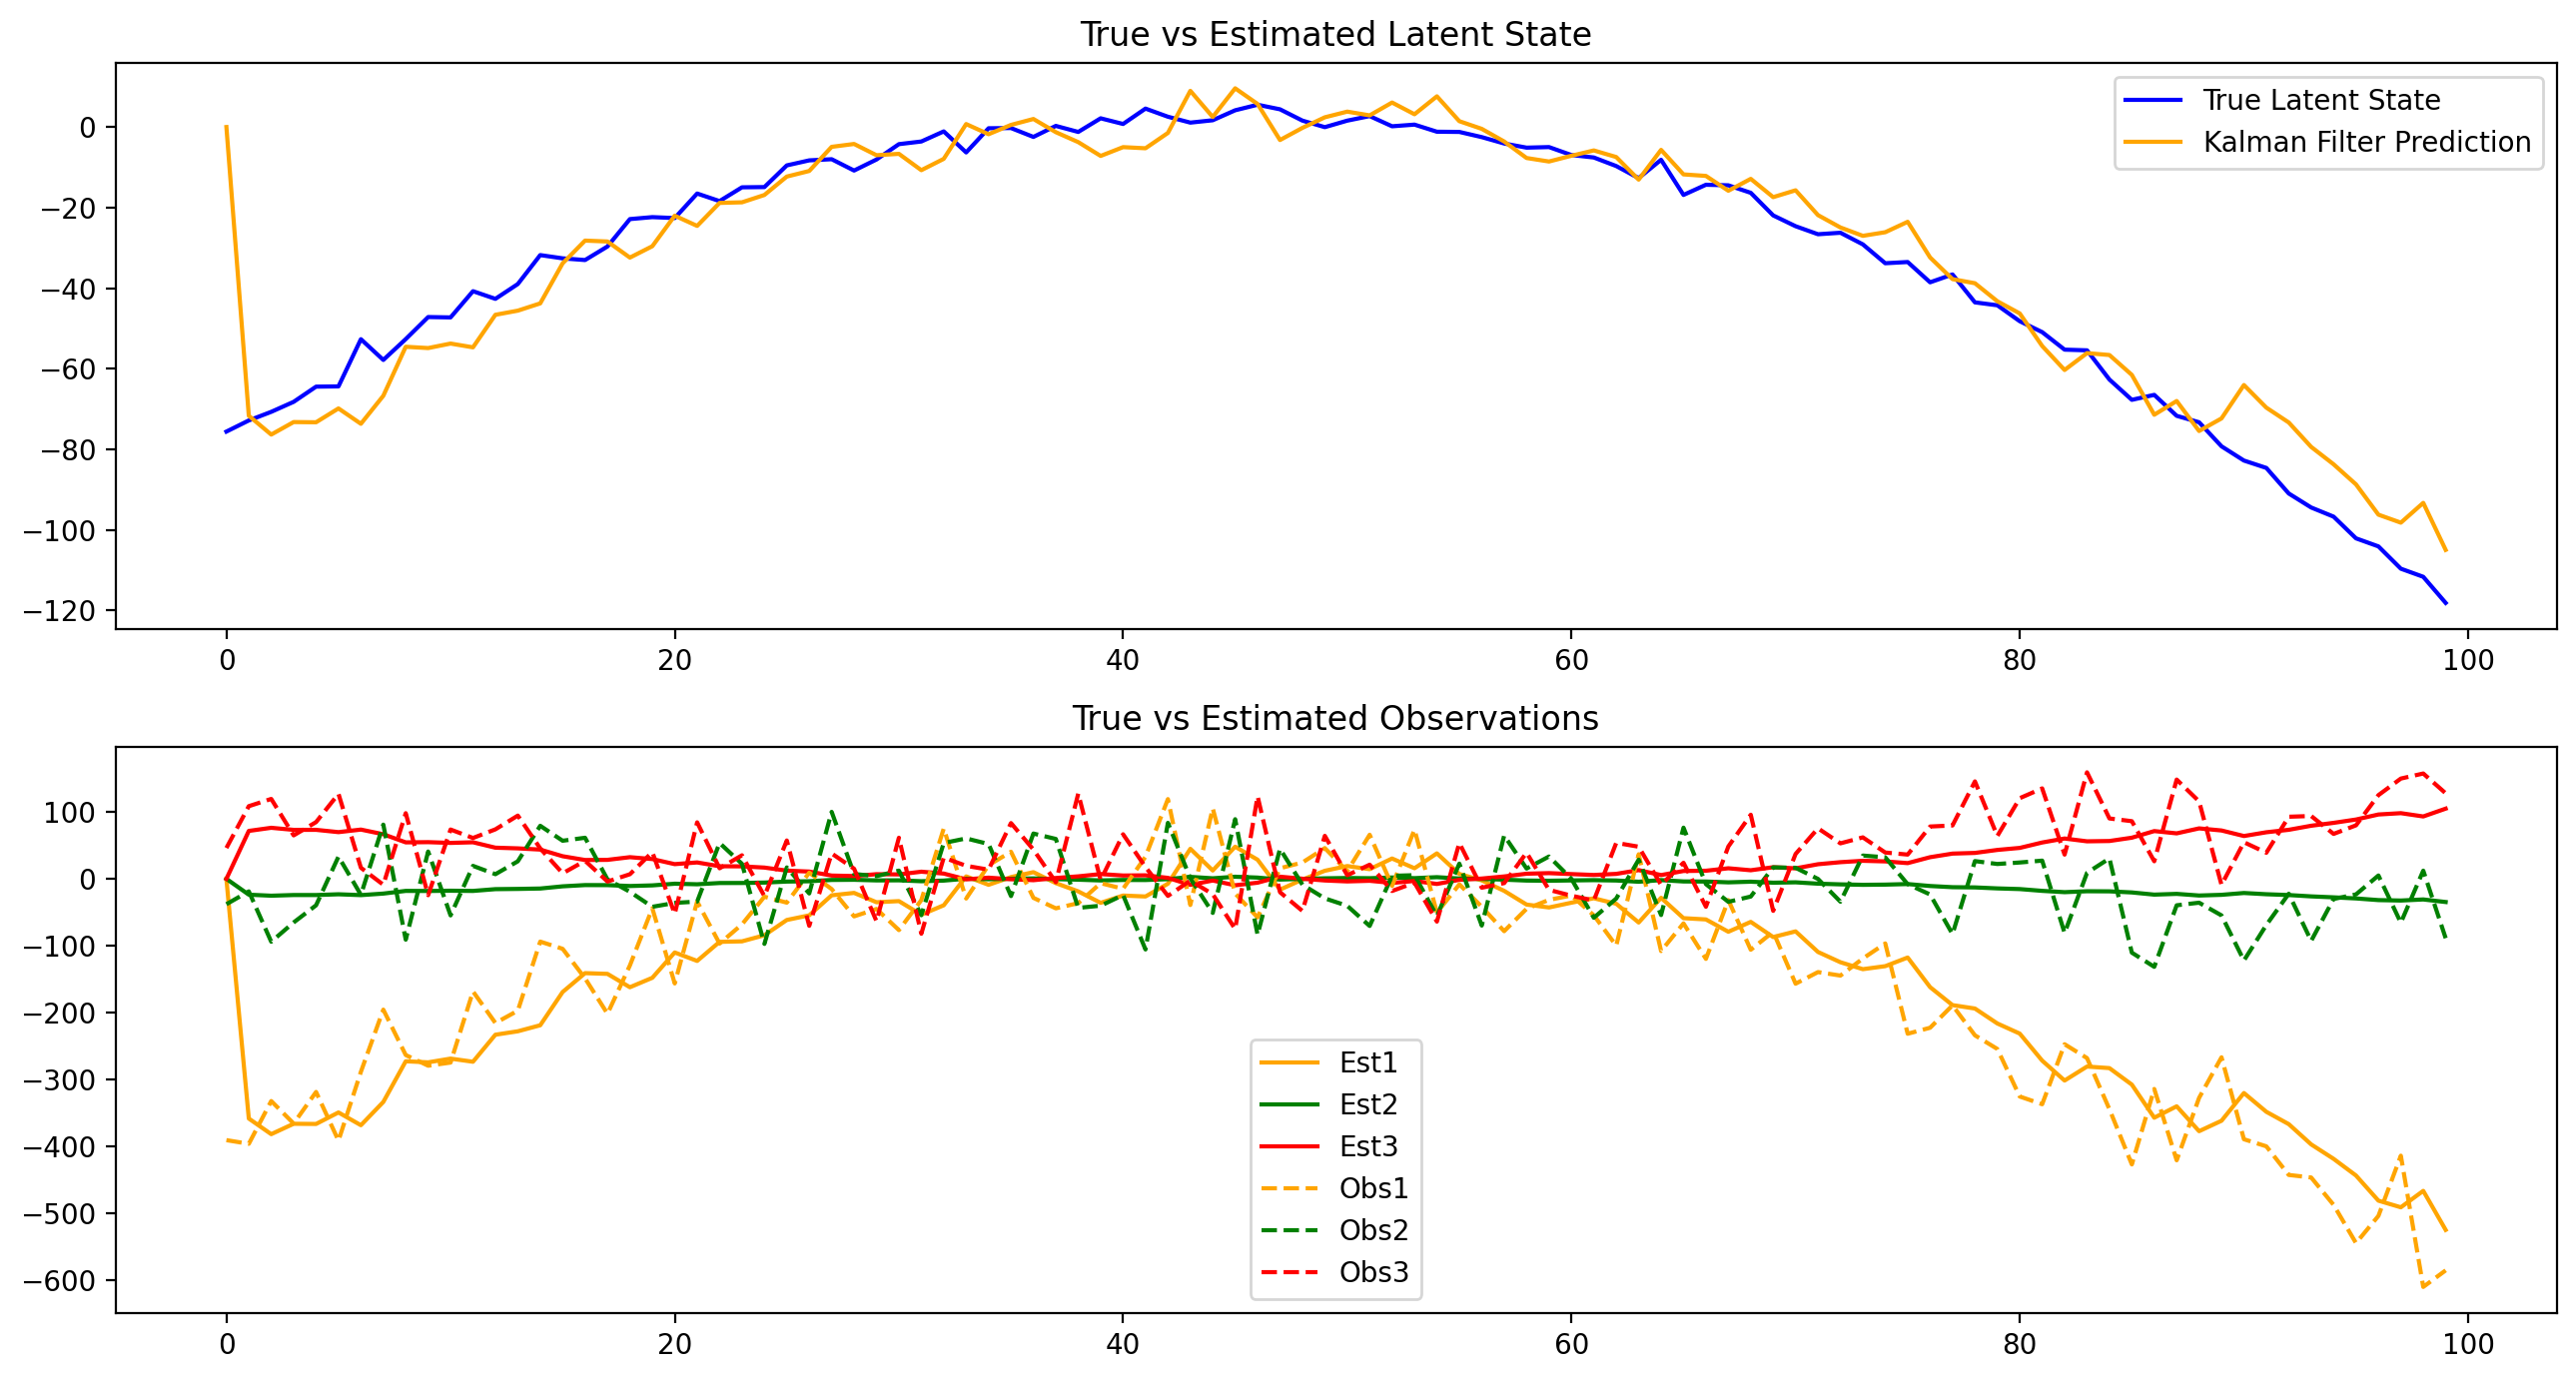

In [375]:
F = np.array([[1]])  # Assuming no change in state

H = np.array([[5],  # First observation directly maps to the state
              [0.33],  # Second observation directly maps to the state
              [-1]]) # Third observation directly maps to the state

Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]]) # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


x = np.linspace(-10, 10, 100)
latent_state = (- (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)).reshape(1,100)
observations = H @ latent_state + np.random.normal(0,50,300).reshape(3,100)



kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state = []
predictions_obs = []

for z in observations.T:
    z = z.reshape(3,1)
    predictions_obs.append(H @ kf.predict()[0])
    predictions_state.append(kf.predict()[0])
    kf.update(z)

import matplotlib.pyplot as plt

# Assuming predictions_obs, observations, latent_state, and predictions are defined

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(latent_state.T)), latent_state.T, label='True Latent State', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(100,1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("True vs Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(100, 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()


In [268]:
observations.shape
Y[:,:,3].T.shape

(3, 81)

## KF on real Data

In [385]:
#data preperation
#tx = pd.read_csv("tx_long.csv")
tx = pd.read_csv("./data/data_scales/TX/tx_long.csv")
pivoted = tx.pivot(index='studentID',columns='meas',values=['PANN01_state','PANN05_state','PANN09_state'])

# Should forward fill these I think. Or drop from analysis?
PANN01_state = pivoted['PANN01_state'].T
PANN05_state = pivoted['PANN05_state'].T
PANN09_state = pivoted['PANN09_state'].T



Y1 = PANN01_state.to_numpy()
Y2 = PANN05_state.to_numpy()
Y3 = PANN09_state.to_numpy()
Y = np.stack((Y1,Y2,Y3),axis=2) #axis=0 would lead to (3, 50, 117)
Y = np.transpose(Y,(1,2,0))
Y.shape

# For getting factor loadings we need the dataset filled. 
# Here we interpolate, forwardfill and backfill the remaining values.
# This isn't super clean, but it at least gets it running. Smarter interpolation / calculation of factor loadings can be done later.w
PANN01_state = pivoted['PANN01_state'].interpolate(axis=1).ffill().bfill().T
PANN05_state = pivoted['PANN05_state'].interpolate(axis=1).ffill().bfill().T
PANN09_state = pivoted['PANN09_state'].interpolate(axis=1).ffill().bfill().T
Y1 = PANN01_state.to_numpy()
Y2 = PANN05_state.to_numpy()
Y3 = PANN09_state.to_numpy()
Y_factors = np.stack((Y1,Y2,Y3),axis=2) #axis=0 would lead to (3, 50, 117)
#Y_factors = np.transpose(Y,(1,2,0))
Y_factors.shape


(50, 117, 3)

#### Factor Loadings

In [386]:
from sklearn.decomposition import FactorAnalysis

In [387]:
transformer = FactorAnalysis(n_components=1, random_state=0)
fit = transformer.fit(Y_factors.reshape(-1,3))
fit.components_.reshape(-1,1)

array([[1.02584791],
       [1.20147747],
       [1.0151294 ]])

In [388]:
H = fit.components_.reshape(-1,1)

In [389]:
H.shape

(3, 1)

In [390]:
H * expected_mean

array([[0.45455588],
       [0.53237779],
       [0.44980648]])

#### The rest

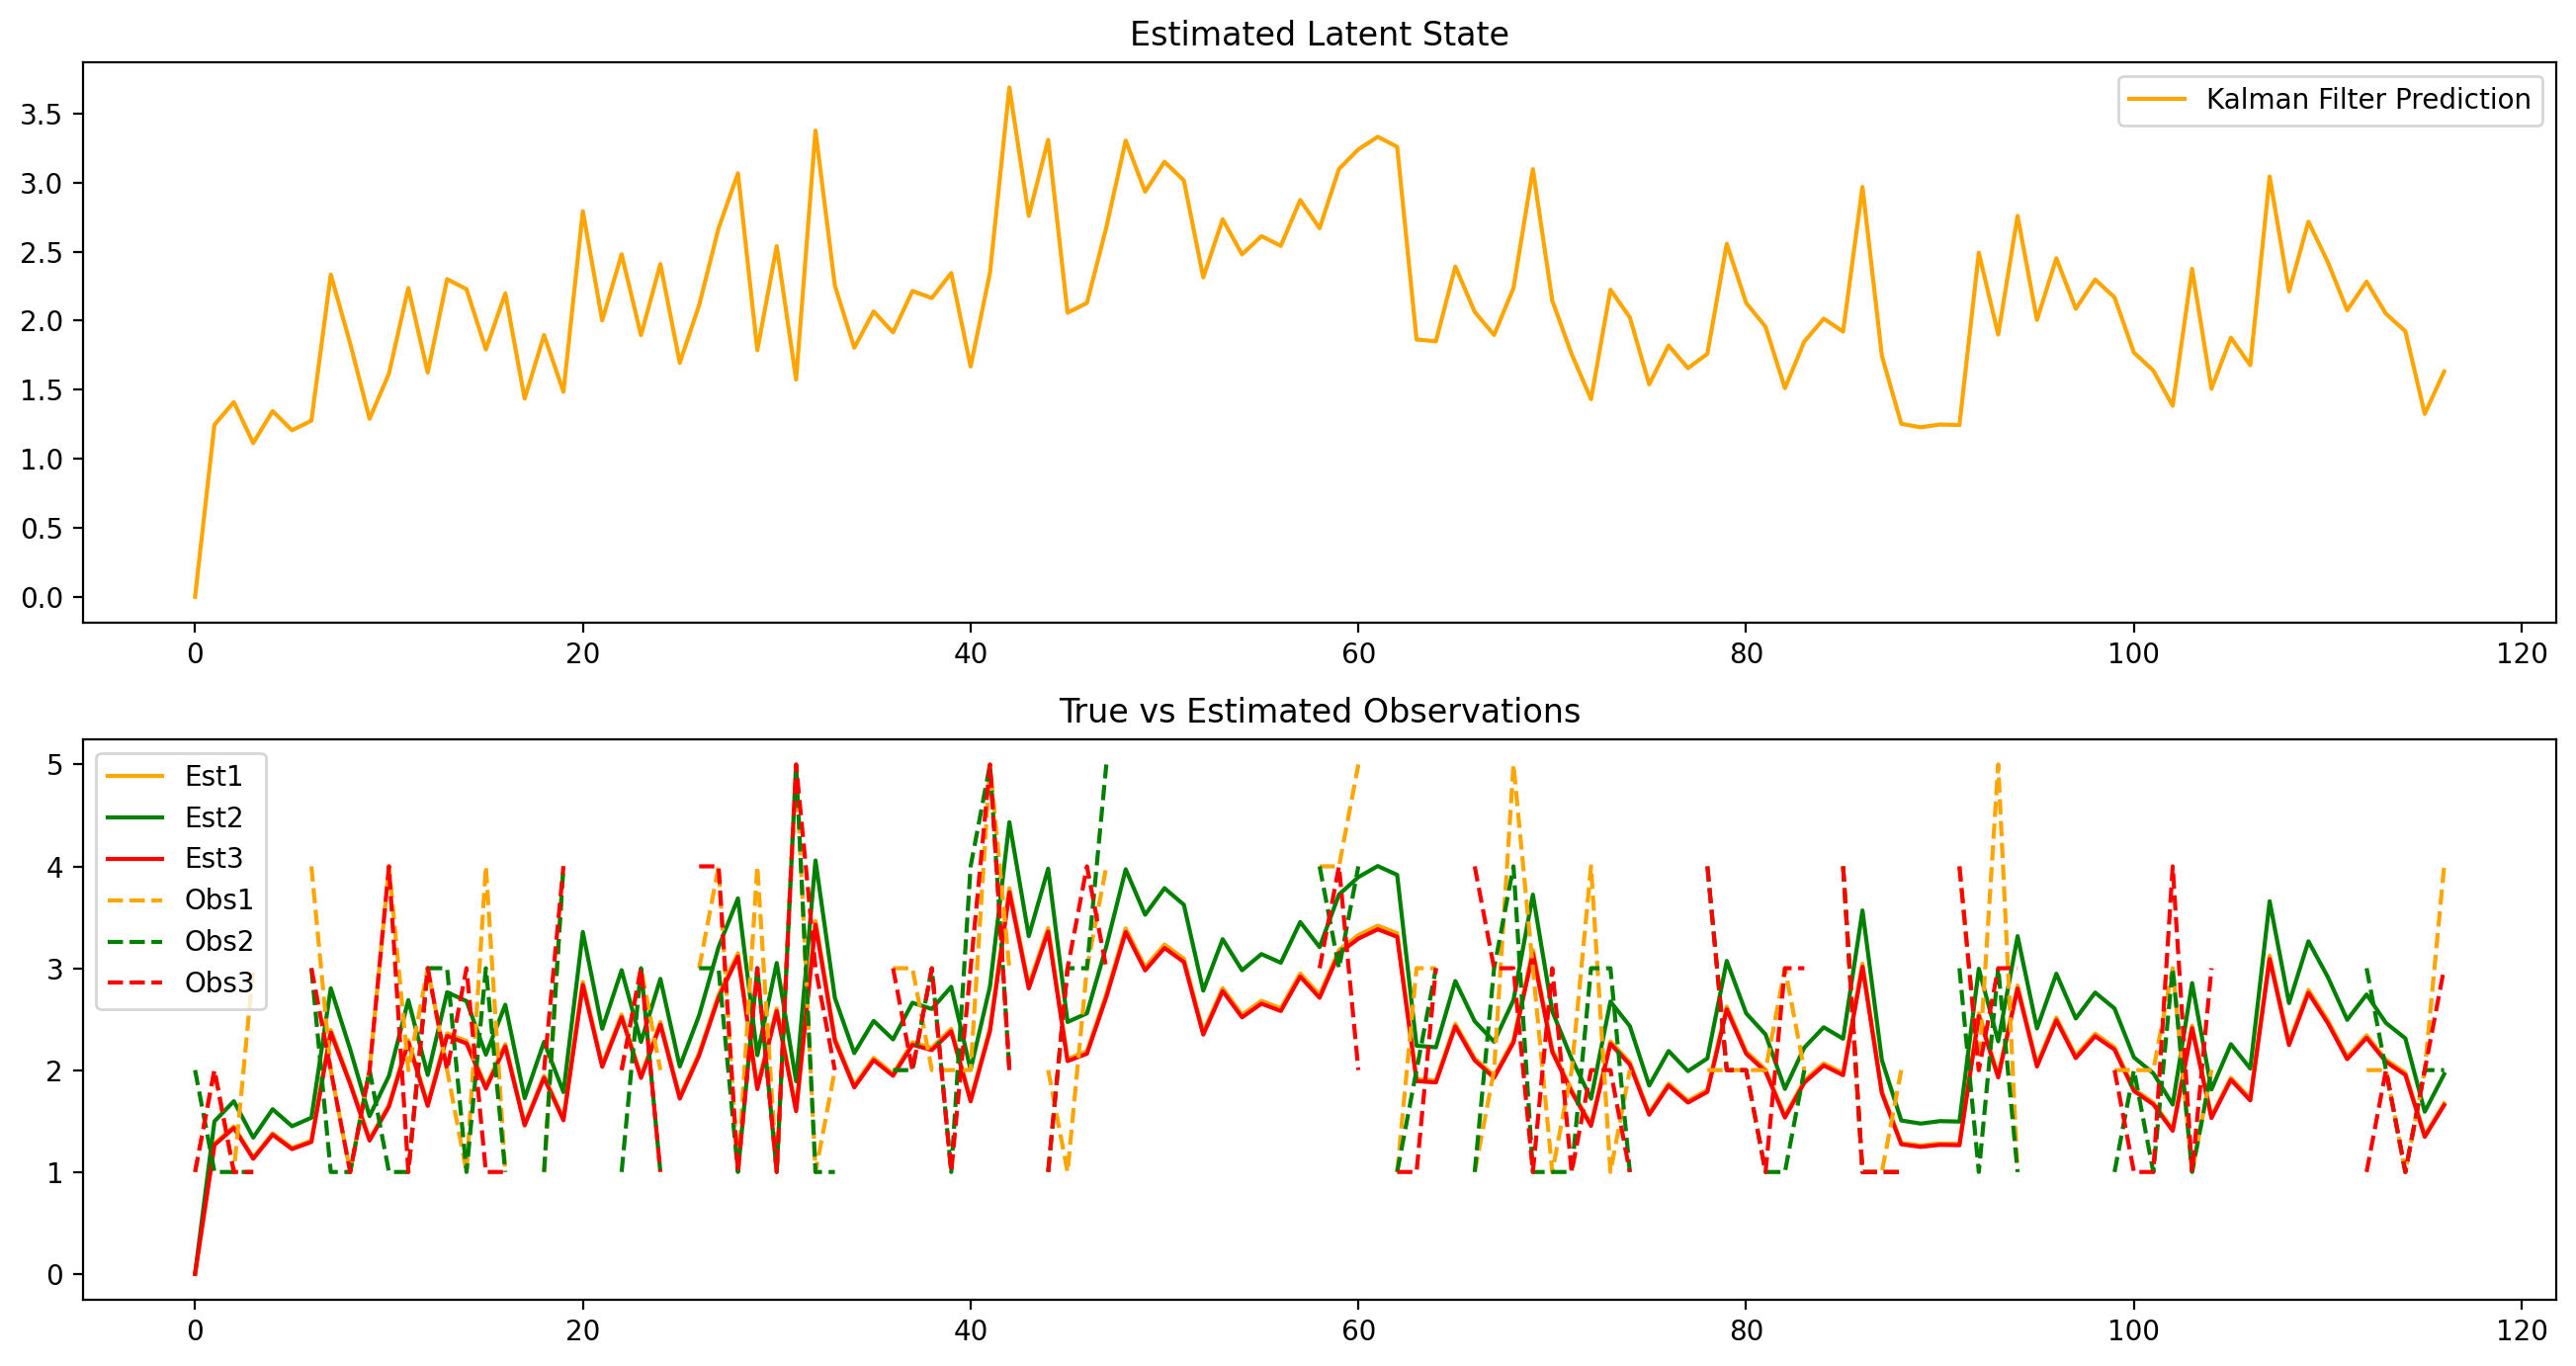

In [395]:
STUDENT = 1

F = np.array([[1]])  # Assuming no change in state


Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]])*0.02 # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


observations = Y[:,:,STUDENT].T


kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state = []
predictions_obs = []
predictions_cov = []

for z in observations.T:
    z = z.reshape(3,1)

    
    if np.isnan(z).any():#filter if nan
        if not predictions_state: #if predictions are empty i.e. the first value is nan, set z to 1,1,1
            z = np.array([2,2,2]).reshape(3,1)
        else:
            expected_mean = np.random.normal(predictions_state[-1],predictions_cov[-1]) # sampling from the last observed step
            z = H @ expected_mean #from latent to observed state
    
    predictions_dummy,prediction_dummy_cov = kf.predict()
    predictions_obs.append(H @ predictions_dummy)
    predictions_state.append(predictions_dummy)
    predictions_cov.append(prediction_dummy_cov)
    kf.update(z)

import matplotlib.pyplot as plt

# Assuming predictions_obs, observations, latent_state, and predictions are defined

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(len(Y),1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(len(Y), 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()




In [393]:
np.isnan(predictions_obs).any()

False

## Smoother (still work in progress)

In [622]:
T = 10
inity = np.array([4,5])
y = np.zeros(T)

y[:len(inity)] = inity
K = np.array([0.4,0.3])

for t in range(T-len(inity)):
    t = t + len(inity)
    idx = list(range(t-len(inity),t))
    print(idx)
    
    y[t] = K @ y[idx]
y

[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]
[5, 6]
[6, 7]
[7, 8]


array([4.        , 5.        , 3.1       , 2.93      , 2.119     ,
       1.8077    , 1.38991   , 1.140053  , 0.8979799 , 0.72541517])

In [163]:
def kalman_smoother(state_estimates, state_covariances, A):
    """
    Kalman smoother implementation for refining state estimates.

    Parameters:
    - state_estimates: Array of estimated latent states (shape: (1, T))
    - state_covariances: Array of state covariance matrices (shape: (1, 1, T))
    - A: State transition matrix (shape: (1, 1))

    Returns:
    - smoothed_state_estimates: Array of smoothed latent states (shape: (1, T))
    """

    T = state_estimates.shape[1]

    smoothed_state_estimates = np.zeros((1, T))

    # Initialization
    smoothed_state_estimates[:, -1] = state_estimates[:, -1]

    for t in range(T-2, -1, -1):
        # Smoothing step
        smoothed_state_estimates[:, t] = state_estimates[:, t] + \
                                         state_covariances[:, :, t] @ A.T @ \
                                         np.linalg.inv(state_covariances[:, :, t+1]) @ \
                                         (smoothed_state_estimates[:, t+1] - A @ state_estimates[:, t+1])

    return smoothed_state_estimates


In [ ]:
def run_model_with_new_data():
    ...